In [1]:
parameter_file = '../parameters/params.yaml'
import yaml
import sys
import pandas as pd
import os
from os.path import join, basename
import glob
import shutil
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

with open(parameter_file,'r') as f:
    doc = yaml.load(f)
    
    
samples = pd.read_csv("../parameters/samples.tsv", sep="\t", index_col=0)
samples
    
data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
#annotation=doc['annotation_gtf']
annotation=doc['annotation']

from Homer import *

os.chdir(doc["results"])

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


In [2]:
from mplh.fig_utils import helper_save
from mplh.color_utils import get_colors
from scipy import stats

# outdir

In [3]:
outdir = "tss_pca"
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [4]:
merged_dir = "merged_all/"

homer_path =  "/data2/resources/software/homer/v4.11_10242019/bin/"
os.environ['PATH'] = f"{homer_path}:{os.environ['PATH']}"
!which homer

merged_f = join(merged_dir, 'samples.merge')
anno_f = merged_f+".anno"
seq_f = anno_f + '.fa'
peaks_with_distance_f = join(merged_dir,'peaks_with_tss_distances.tsv')
peaks_expression_f = merged_f + '.peaksexpression'

peaks_with_distance_size1_f = peaks_with_distance_f.replace('.tsv',"")+ "_size1.tsv"
peaks_with_distance_size1_bed_f = peaks_with_distance_size1_f.replace('.tsv',".bed")
peaks_with_distance_size1_noCDS_bed_f =peaks_with_distance_size1_bed_f.replace('.bed',"noCDS.bed")
# out_dir = join(main_dir, "peak_files")
# if not os.path.exists(out_dir):
#     os.mkdir(out_dir)



peaks_expression = pd.read_csv(peaks_expression_f,sep='\t', index_col=0)
peaks_expression.columns = map(lambda x: basename(x).split('.')[0], peaks_expression.columns)
peaks_expression_norm = peaks_expression/peaks_expression.sum(axis=0)
peaks_expression_norm_log2 = np.log2(peaks_expression_norm+1)
peaks_expression_norm_log2_z  = stats.zscore(peaks_expression_norm_log2,axis=1)

/data2/resources/software/homer/v4.11_10242019/bin//homer



# All TSS Samples

In [5]:
samples["Tissue"]
#map(peaks_expression.columns
tis_map = {}
for i in peaks_expression.columns:
    for j in samples["Tissue"].unique():
        if j in i:
            if i in tis_map:
                print("Already here!", i)
            else:
                tis_map[i] = j
tis_map

{'MiscOrgans_START1_and_MiscOrgans_startinput1': 'MiscOrgans',
 'Liver_START2_and_Liver_startinput1': 'Liver',
 'Brain_GROCap1_and_Brain_GRO1': 'Brain',
 'Liver_START1_and_Liver_startinput1': 'Liver',
 'Lung_GROCap1_and_Lung_GRO1': 'Lung',
 'Brain_START3_and_Brain_startinput1': 'Brain',
 'Heart_START1_and_Heart_startinput1': 'Heart',
 'CHO_GROCap2_and_CHO_GRO1': 'CHO',
 'Heart_START2_and_Heart_startinput1': 'Heart',
 'Liver_GROCap1_and_Liver_GRO1': 'Liver',
 'Pancreas_START2_and_Pancreas_startinput1': 'Pancreas',
 'BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1': 'BMDM1hKLA',
 'Pancreas_START1_and_Pancreas_startinput1': 'Pancreas',
 'FemaleReproductive_START2_and_FemaleReproductive_startinput1': 'FemaleReproductive',
 'Muscle_START1_and_Muscle_startinput1': 'Muscle',
 'Brain_START1_and_Brain_startinput1': 'Brain',
 'Muscle_START2_and_Muscle_startinput1': 'Muscle',
 'Brain_START2_and_Brain_startinput2': 'Brain',
 'Brain_START1_and_Brain_startinput2': 'Brain',
 'CHO_GROCap1_and_CHO_GRO2': 'CHO',
 

In [6]:
#map(peaks_expression.columns
exp_map = {}
for i in peaks_expression.columns:
    if 'GRO' in i:
        exp_map[i] = 'GROCap'
    elif 'START' in i:
        exp_map[i] = 'START'
    else:
        print('No experiment assigned')

exp_map

{'MiscOrgans_START1_and_MiscOrgans_startinput1': 'START',
 'Liver_START2_and_Liver_startinput1': 'START',
 'Brain_GROCap1_and_Brain_GRO1': 'GROCap',
 'Liver_START1_and_Liver_startinput1': 'START',
 'Lung_GROCap1_and_Lung_GRO1': 'GROCap',
 'Brain_START3_and_Brain_startinput1': 'START',
 'Heart_START1_and_Heart_startinput1': 'START',
 'CHO_GROCap2_and_CHO_GRO1': 'GROCap',
 'Heart_START2_and_Heart_startinput1': 'START',
 'Liver_GROCap1_and_Liver_GRO1': 'GROCap',
 'Pancreas_START2_and_Pancreas_startinput1': 'START',
 'BMDM1hKLA_GROCap1_and_BMDM1hKLA_GRO1': 'GROCap',
 'Pancreas_START1_and_Pancreas_startinput1': 'START',
 'FemaleReproductive_START2_and_FemaleReproductive_startinput1': 'START',
 'Muscle_START1_and_Muscle_startinput1': 'START',
 'Brain_START1_and_Brain_startinput1': 'START',
 'Muscle_START2_and_Muscle_startinput1': 'START',
 'Brain_START2_and_Brain_startinput2': 'START',
 'Brain_START1_and_Brain_startinput2': 'START',
 'CHO_GROCap1_and_CHO_GRO2': 'GROCap',
 'Brain_START2_and_B

## Color by sample type

In [7]:
color_map, name_map, p = get_colors(scheme='categorical', names=samples["Tissue"].values, n_colors=len(samples["Tissue"].unique()), use_white=False)
sns.set_palette(sns.color_palette(color_map.values()))

Generating palette: 100% |######################################| Time: 0:00:12


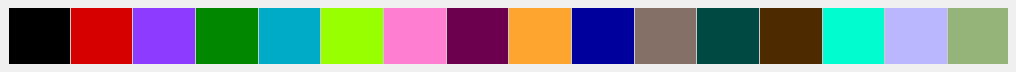

In [8]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

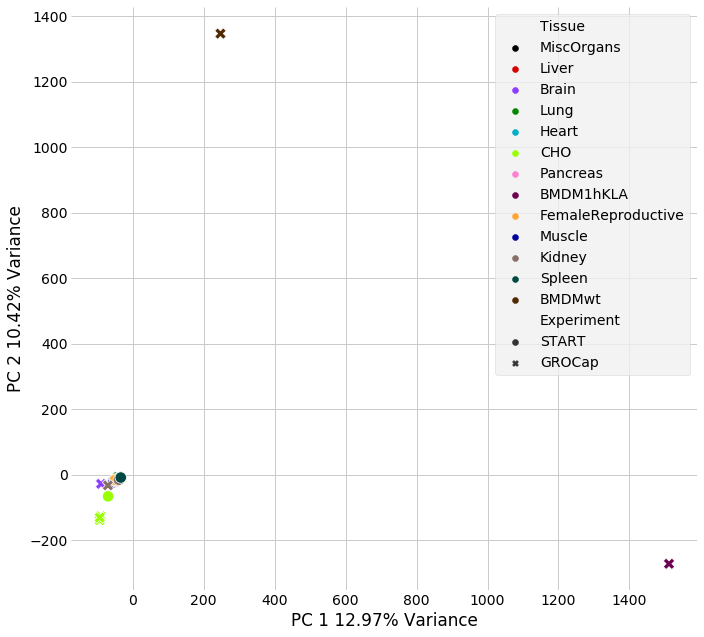

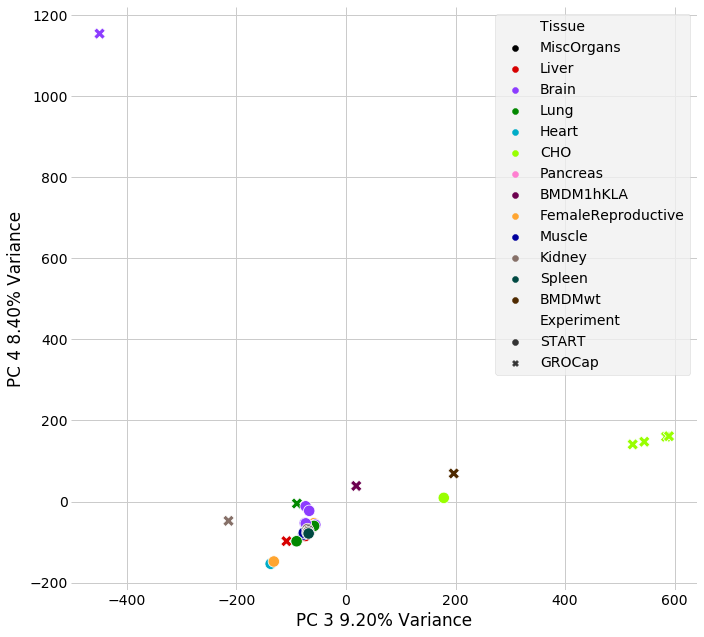

In [9]:

## Run with n=4 components
svd = TruncatedSVD(n_components=4)#peaks_expression_norm_log2_z.shape[1]-1) #4, n_iter=10)
svd.fit(peaks_expression_norm_log2_z.transpose())
### Plot first 2 axes
pc_axes_peak_by_motif = svd.transform(peaks_expression_norm_log2_z.transpose())

out_df = pd.DataFrame(pc_axes_peak_by_motif[:,:4], index = peaks_expression.columns.values)
out_df["Experiment"] = out_df.index.map(exp_map)
out_df["Experiment Markers"] = out_df["Experiment"].map({"GROCap":'+', "START": '*'})
out_df["Tissue"] = out_df.index.map(tis_map)

fig, ax = plt.subplots(1, figsize=(10,10))

sns.scatterplot(0, 1,data=out_df, hue='Tissue',style='Experiment', x_jitter=True ,
                s=130,ax=ax)#,plot_kws={'s':130}, ax=ax)
plt.xlabel(f"PC 1 {100*svd.explained_variance_ratio_[0]:.2f}% Variance")
plt.ylabel(f"PC 2 {100*svd.explained_variance_ratio_[1]:.2f}% Variance")

curr_f = join(outdir,"all_samples_pca_1_2")
helper_save(curr_f)
out_df.to_csv(curr_f + '.csv')

fig, ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(2, 3,data=out_df, hue='Tissue',style='Experiment', x_jitter=True ,
                s=130,ax=ax)#,plot_kws={'s':130}, ax=ax)
plt.xlabel(f"PC 3 {100*svd.explained_variance_ratio_[2]:.2f}% Variance")
plt.ylabel(f"PC 4 {100*svd.explained_variance_ratio_[3]:.2f}% Variance")

curr_f = join(outdir,"all_samples_pca_3_4")
helper_save(curr_f)
out_df.to_csv(curr_f + '.csv')

In [10]:
def run_pca(expr_df,samples_to_drop=None, f_save=None, top_var = 0, out_f=None, label=None):
    if samples_to_drop is not None:
        expr_df = expr_df.drop(samples_to_drop)
    #Remove any 0s across all samples
    expr_df = expr_df[~((expr_df==0).all(axis=1))]

    peaks_expression_norm_log2_z = stats.zscore(expr_df,axis=1)
    print(peaks_expression_norm_log2_z.shape)
    ## Run with n=4 components
    svd = TruncatedSVD(n_components=4)#peaks_expression_norm_log2_z.shape[1]-1) #4, n_iter=10)
    svd.fit(peaks_expression_norm_log2_z.transpose())
    ### Plot first 2 axes
    pc_axes_peak_by_motif = svd.transform(peaks_expression_norm_log2_z.transpose())

    out_df = pd.DataFrame(pc_axes_peak_by_motif[:,:4], index = expr_df.columns.values,
                         columns=map(lambda x: f"PC {x}",np.arange(1,5)))

    out_df["Experiment"] = out_df.index.map(exp_map)
    out_df["Experiment Markers"] = out_df["Experiment"].map({"GROCap":'+', "START": '*'})
    out_df["Tissue"] = out_df.index.map(tis_map)

    fig, ax = plt.subplots(1, figsize=(10,10))
    sns.scatterplot("PC 1", "PC 2",data=out_df, hue='Tissue',style='Experiment', x_jitter=True ,
                    s=130,ax=ax)#,plot_kws={'s':130}, ax=ax)
    plt.xlabel(f"PC 1 {100*svd.explained_variance_ratio_[0]:.2f}% Variance")
    plt.ylabel(f"PC 2 {100*svd.explained_variance_ratio_[1]:.2f}% Variance")
    if label is not None:
        plt.title(label)
    if out_f is not None:
        helper_save(out_f+ "_pc_1_2")
        out_df.to_csv(out_f + '.csv')

    fig, ax = plt.subplots(1, figsize=(10,10))
    sns.scatterplot("PC 3", "PC 4",data=out_df, hue='Tissue',style='Experiment', x_jitter=True ,
                    s=130,ax=ax)#,plot_kws={'s':130}, ax=ax)
    plt.xlabel(f"PC 3 {100*svd.explained_variance_ratio_[2]:.2f}% Variance")
    plt.ylabel(f"PC 4 {100*svd.explained_variance_ratio_[3]:.2f}% Variance")
    if label is not None:
        plt.title(label)
    if out_f is not None:
        helper_save(out_f+ "_pc_3_4")
    return

## Top variable peaks only

## Using top 3000 variable peaks

(30000, 35)
(3000, 35)
(300, 35)


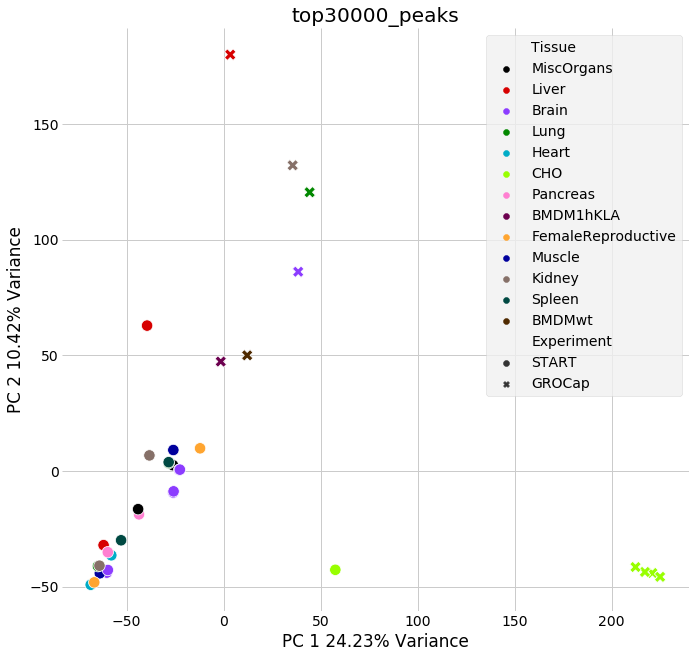

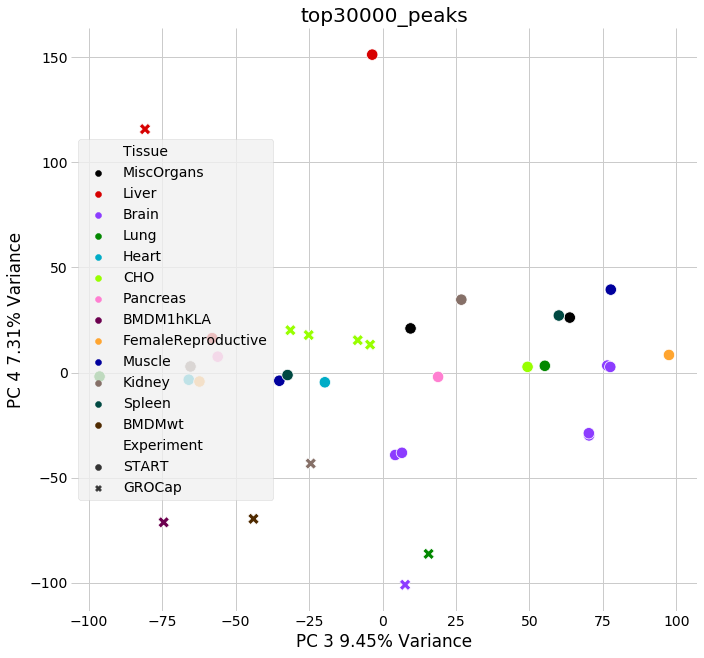

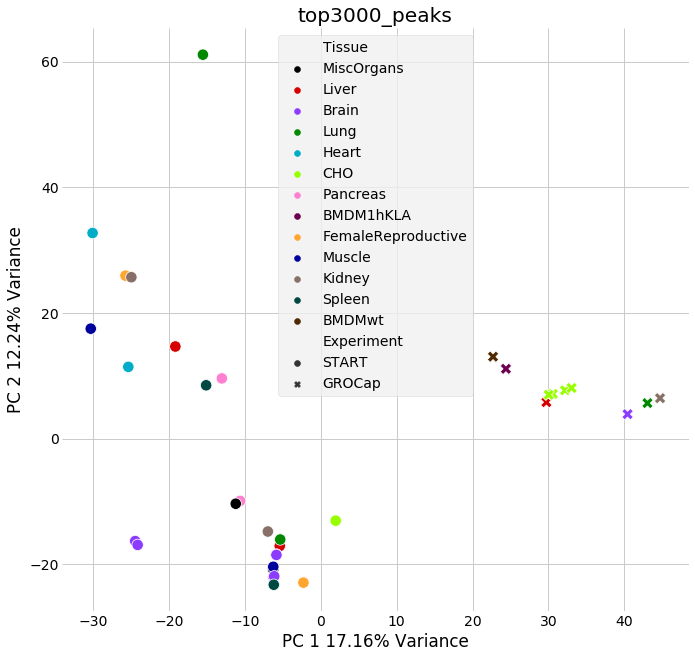

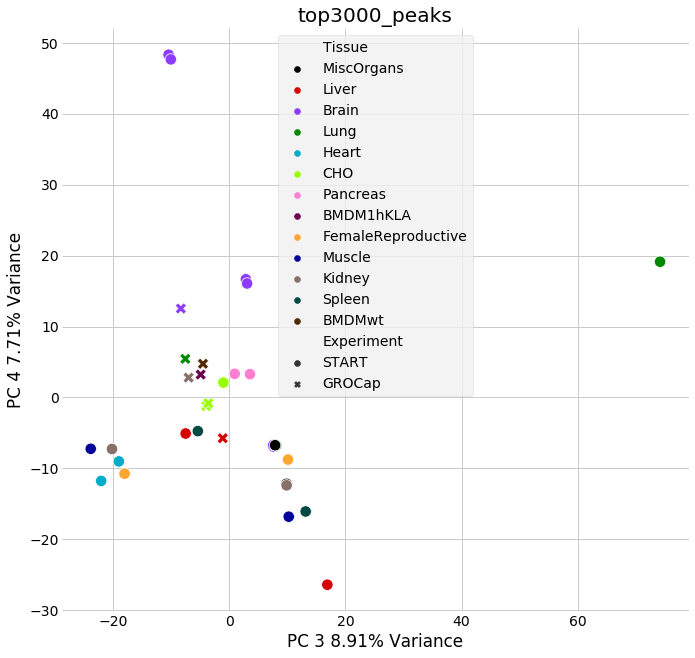

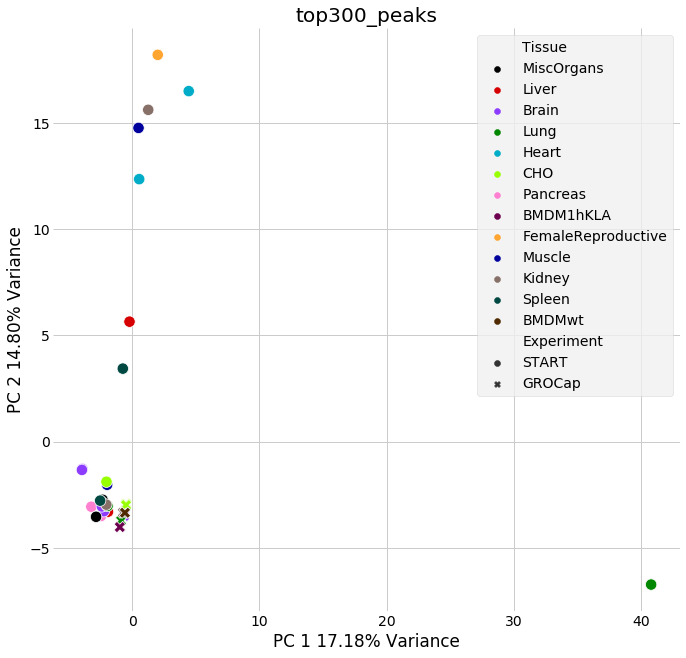

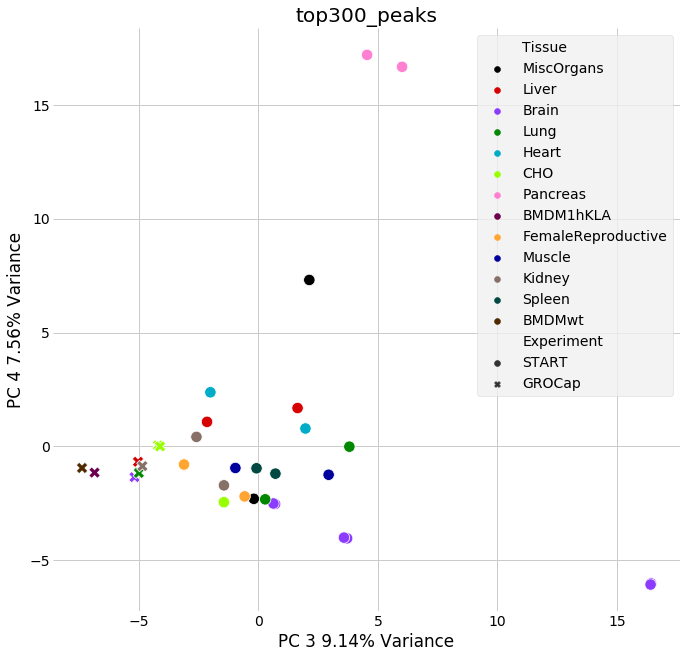

In [11]:
top_vars=30000
inds_to_keep = peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
curr_f = f"all_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
run_pca(peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")

top_vars=3000
curr_f = f"all_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
inds_to_keep = peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
run_pca(peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")

top_vars=300
curr_f = f"all_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
inds_to_keep = peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
run_pca(peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")


### only csRNA

(285953, 25)
(30000, 25)
(3000, 25)
(300, 25)


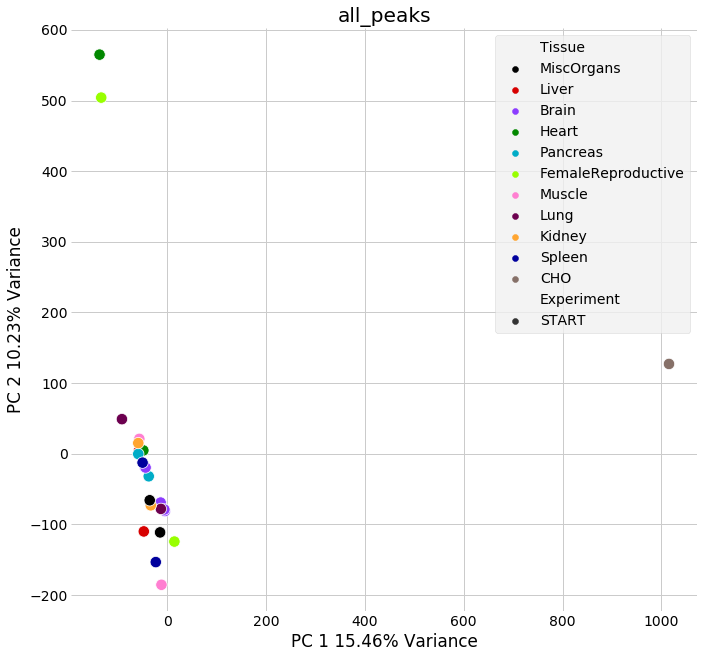

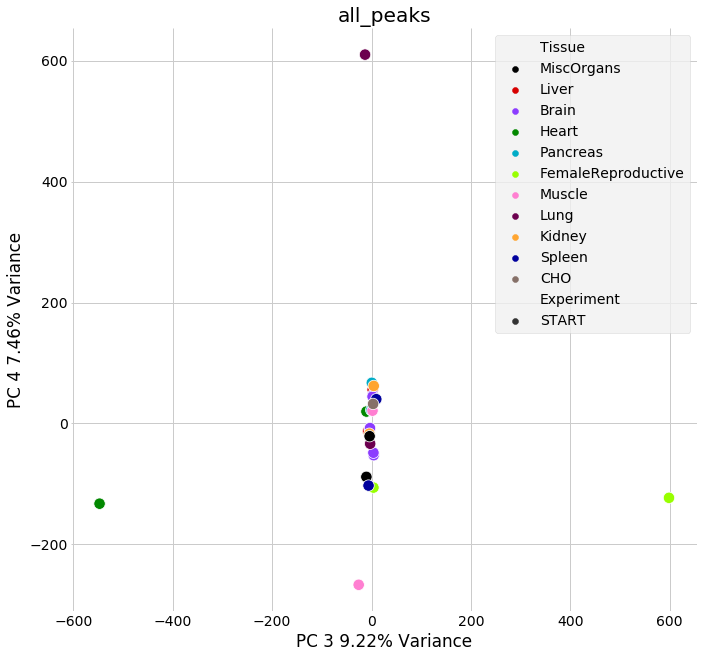

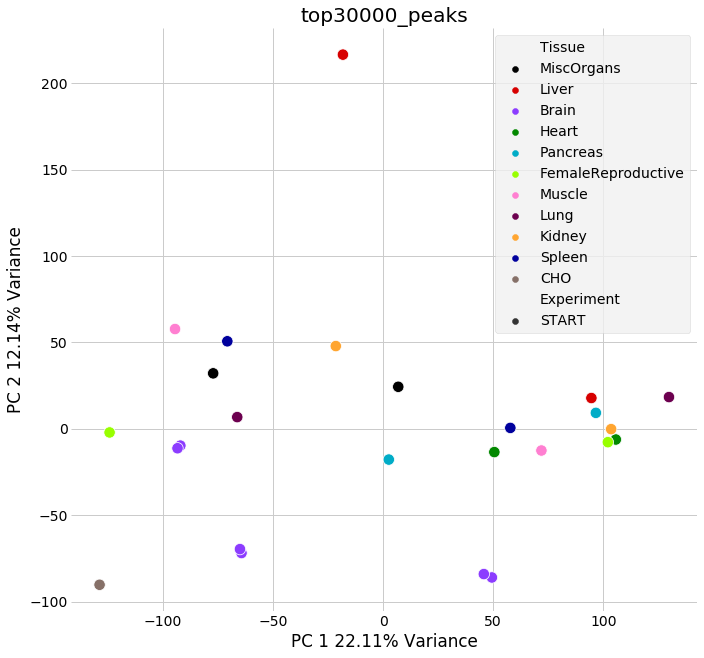

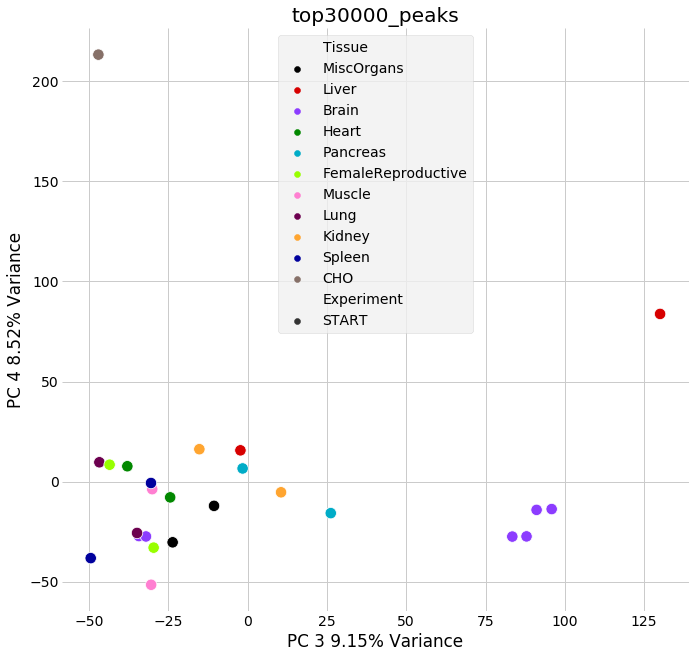

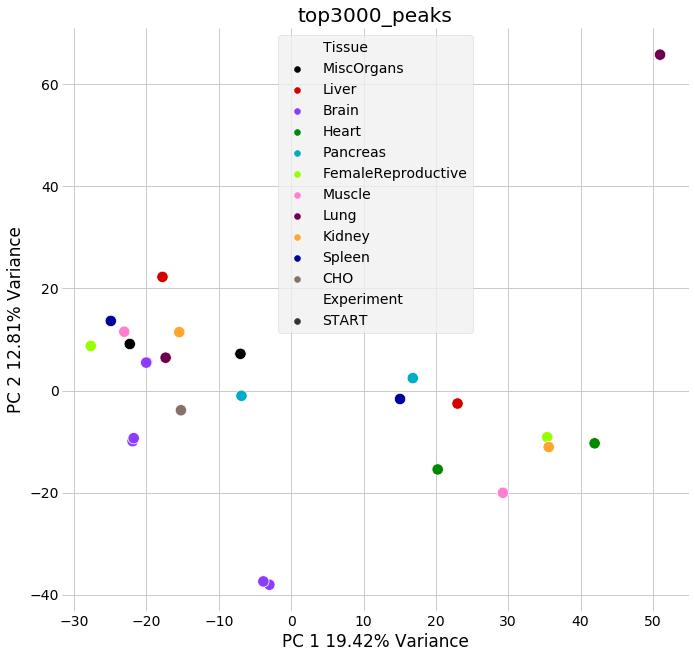

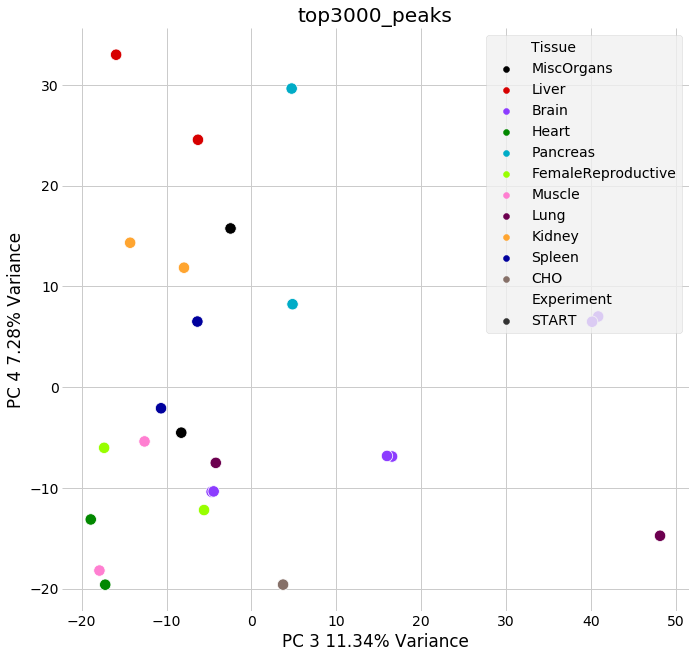

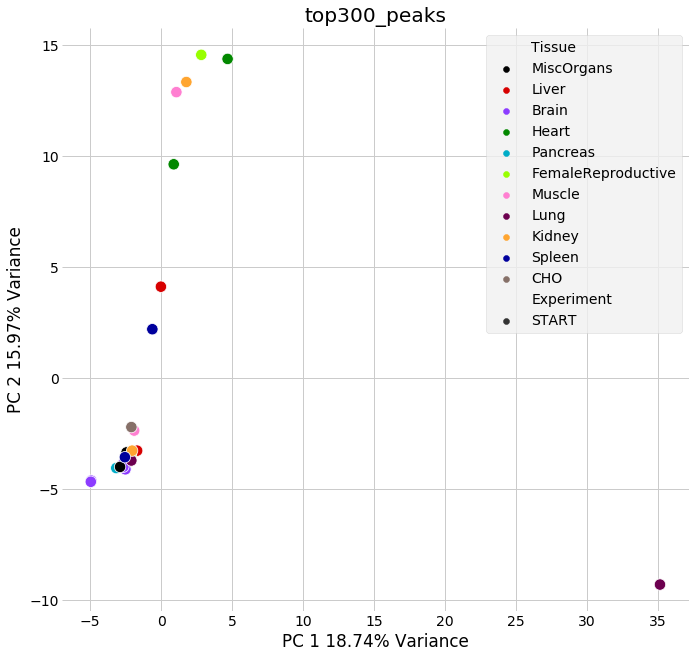

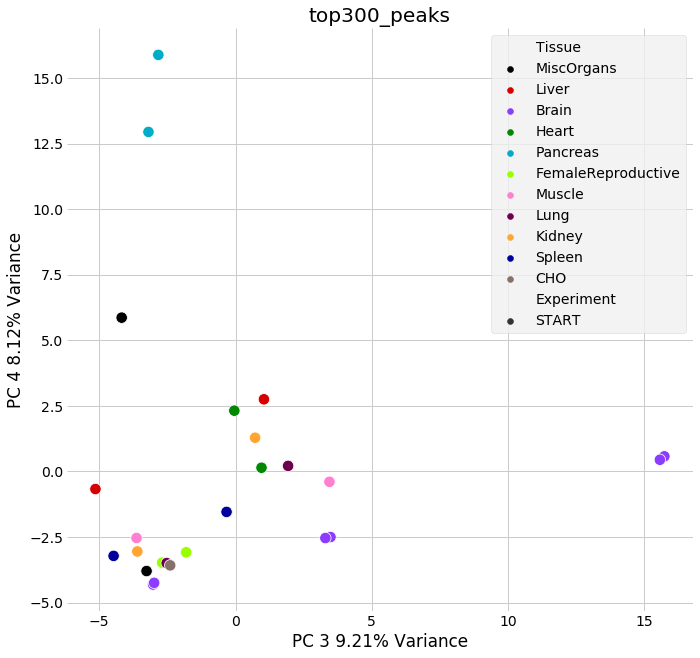

In [17]:
csrna_inds = []
for i in exp_map:
    if exp_map[i] == "START":
        csrna_inds.append(i)
csrna_peaks_expression_norm_log2 = peaks_expression_norm_log2.loc[:,csrna_inds]
#csrna_peaks_expression_norm_log2



curr_f = f"csRNA_samples_peaks_log2"
curr_f = join(outdir, curr_f)
run_pca(csrna_peaks_expression_norm_log2,out_f=curr_f, label=f"all_peaks")

top_vars=30000
inds_to_keep = csrna_peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
curr_f = f"csRNA_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
run_pca(csrna_peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")

top_vars=3000
curr_f = f"csRNA_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
inds_to_keep = csrna_peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
run_pca(csrna_peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")

top_vars=300
curr_f = f"csRNA_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
inds_to_keep = csrna_peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
run_pca(csrna_peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")


(374423, 10)
(30000, 10)
(3000, 10)
(300, 10)


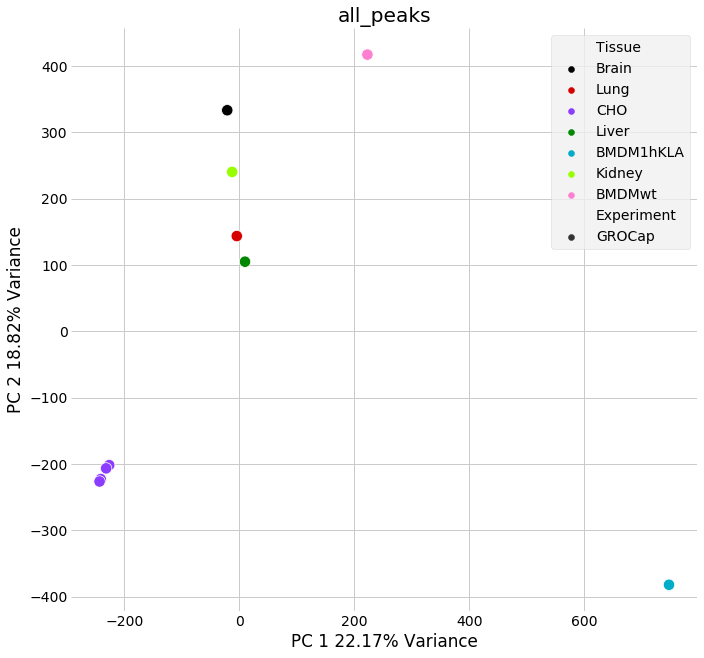

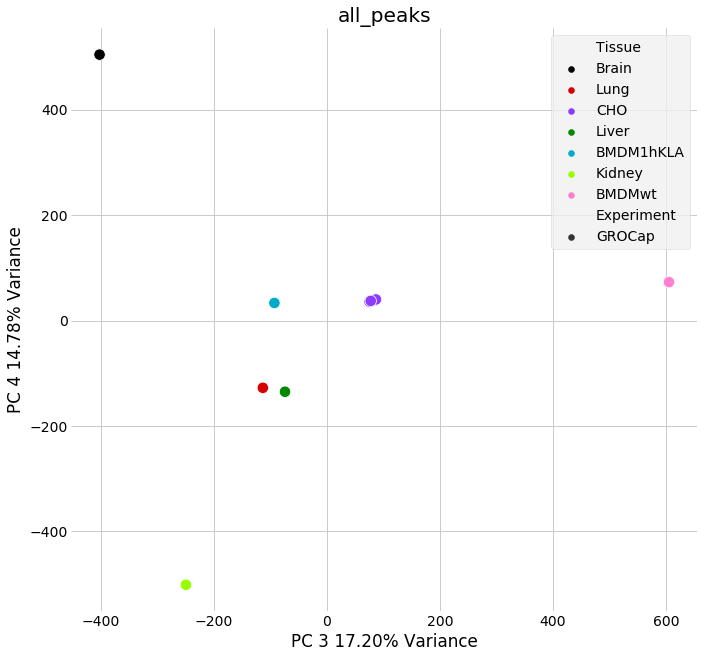

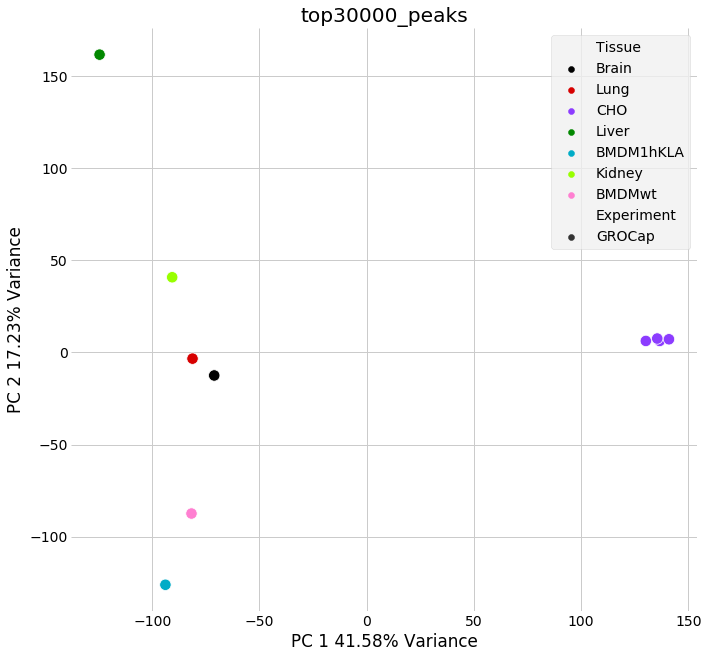

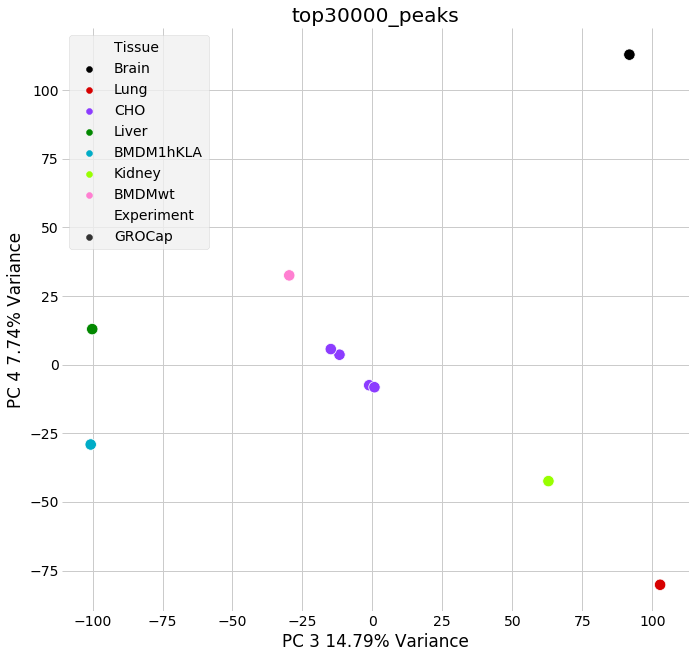

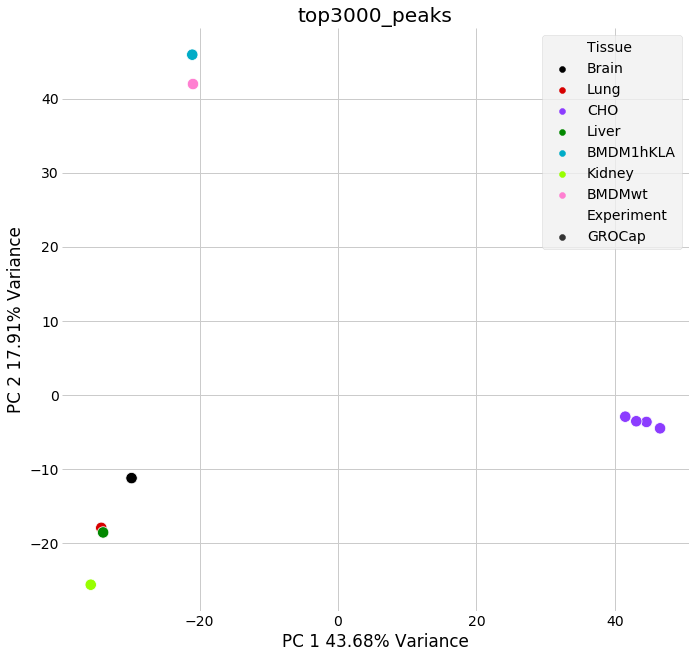

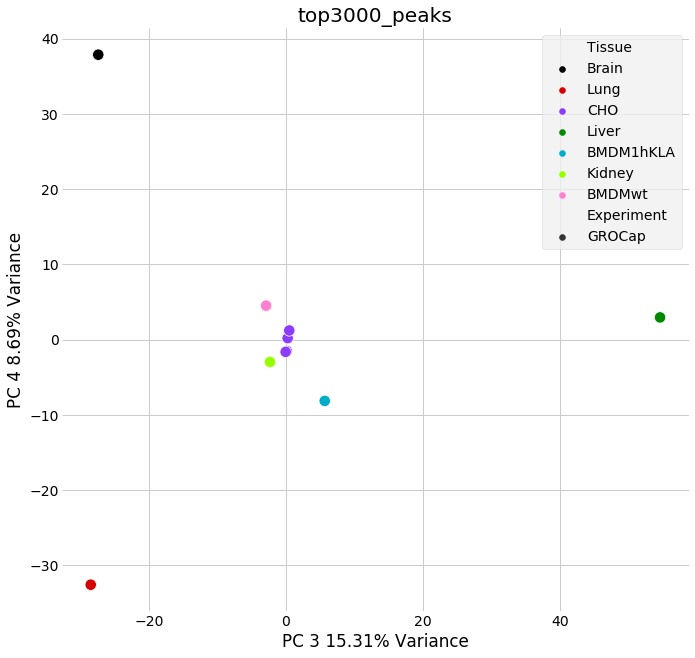

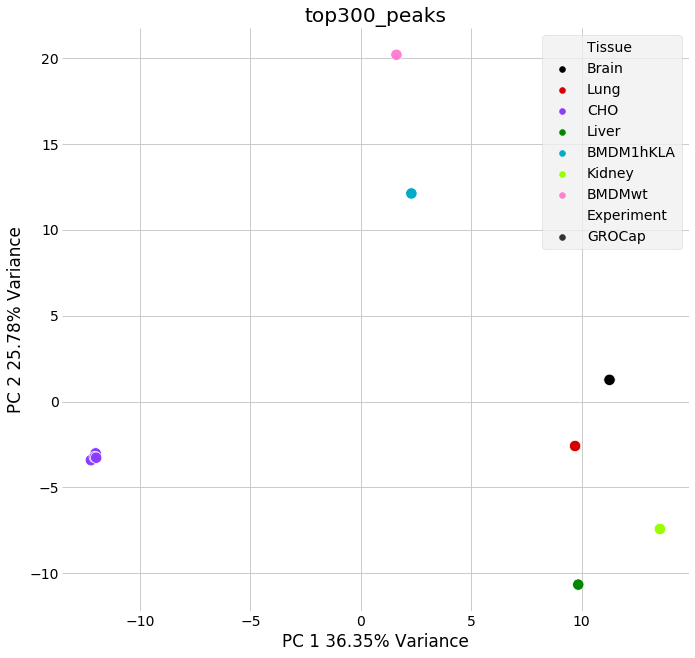

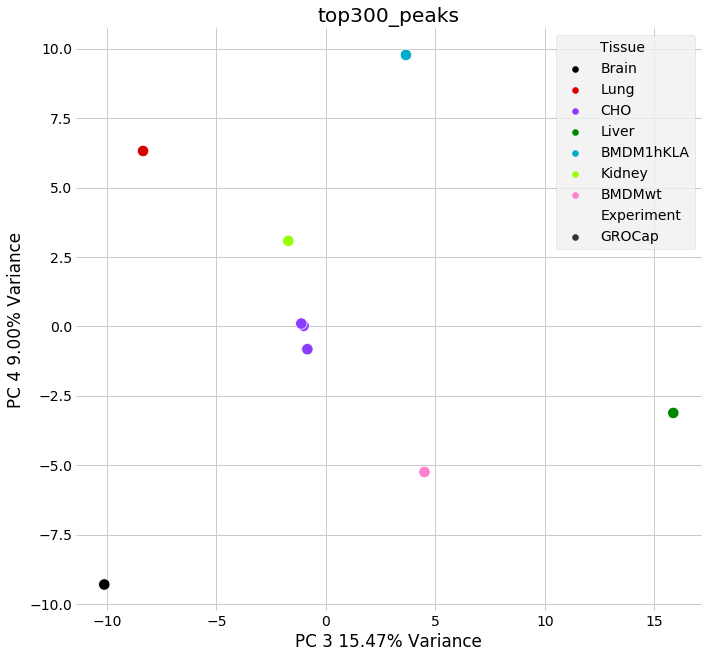

In [18]:
grocap_inds = []
for i in exp_map:
    if exp_map[i] == "GROCap":
        grocap_inds.append(i)
grocap_peaks_expression_norm_log2 = peaks_expression_norm_log2.loc[:,grocap_inds]
#grocap_peaks_expression_norm_log2



curr_f = f"grocap_samples_peaks_log2"
curr_f = join(outdir, curr_f)
run_pca(grocap_peaks_expression_norm_log2,out_f=curr_f, label=f"all_peaks")

top_vars=30000
inds_to_keep = grocap_peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
curr_f = f"grocap_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
run_pca(grocap_peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")

top_vars=3000
curr_f = f"grocap_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
inds_to_keep = grocap_peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
run_pca(grocap_peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")

top_vars=300
curr_f = f"grocap_samples_top{top_vars}_peaks_log2"
curr_f = join(outdir, curr_f)
inds_to_keep = grocap_peaks_expression_norm_log2.var(axis=1).sort_values(ascending=False).index[:top_vars]
run_pca(grocap_peaks_expression_norm_log2.loc[inds_to_keep],out_f=curr_f, label=f"top{top_vars}_peaks")


## Plot tss distribution

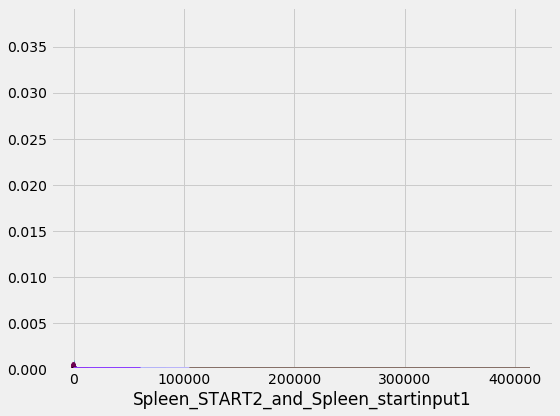

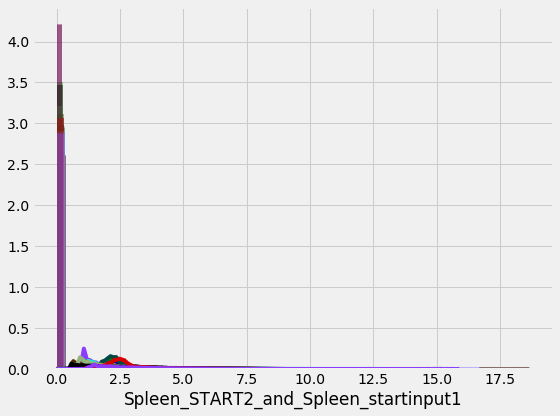

In [13]:
f, ax = plt.subplots()
for col in peaks_expression.columns:
    sns.distplot((peaks_expression_norm*1e6)[col], ax=ax)#, color=color_map[tis_map[col]])
plt.tight_layout() 

f, ax = plt.subplots()
for col in peaks_expression.columns:
    sns.distplot((np.log2(peaks_expression_norm*1e6+1))[col], ax=ax)#, color=color_map[tis_map[col]])
plt.tight_layout() 


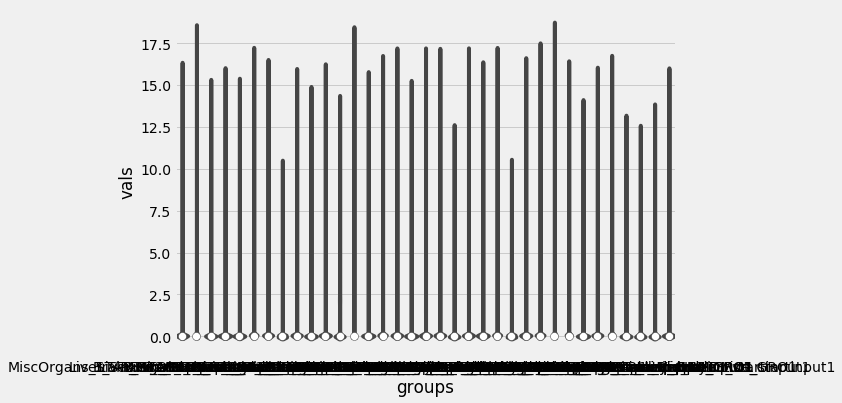

In [14]:
df = np.log2(peaks_expression_norm*1e6+1)
#df.melt(var_name='groups', value_name='vals')
sns.violinplot(x="groups", y="vals", data=df.melt(var_name='groups', value_name='vals'))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

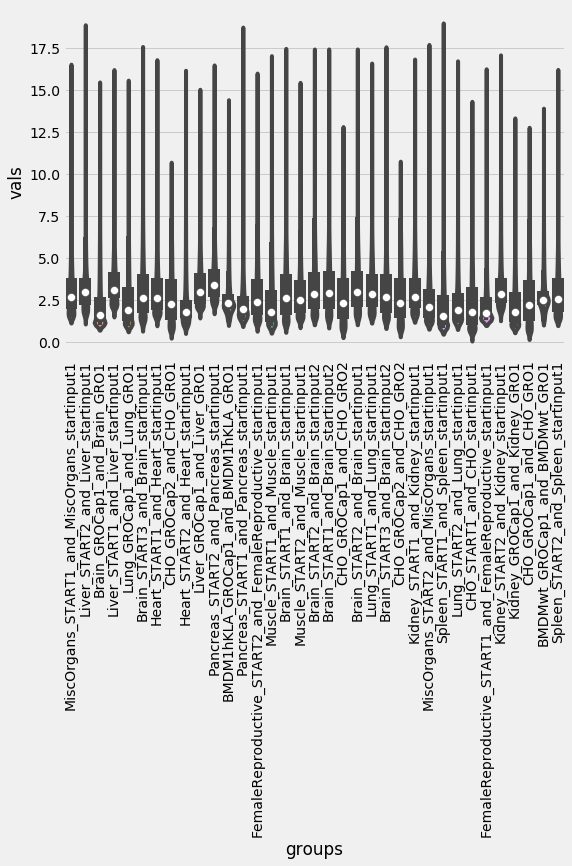

In [15]:
df = np.log2(peaks_expression_norm*1e6+1).melt(var_name='groups', value_name='vals')
#df.melt(var_name='groups', value_name='vals')

sns.violinplot(x="groups", y="vals", data=df[df['vals']>0])
plt.xticks(rotation=90)

## Remove the two outliers and rerun

(434951, 33)


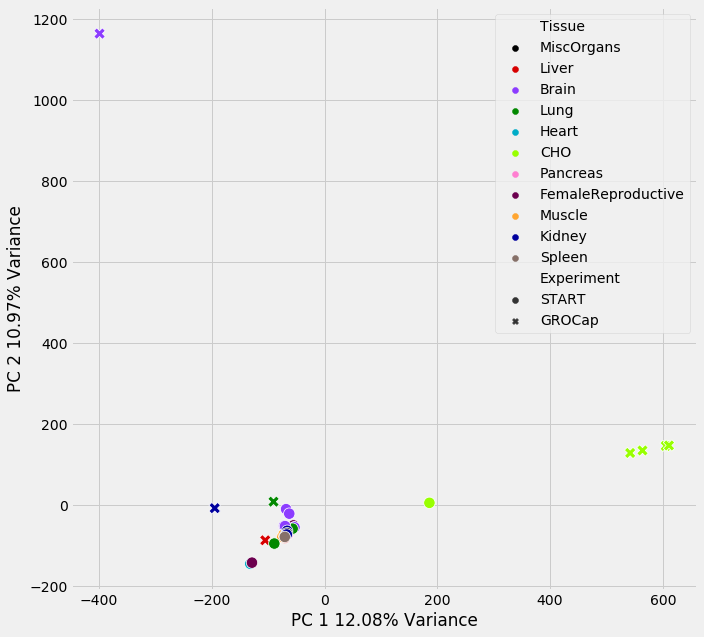

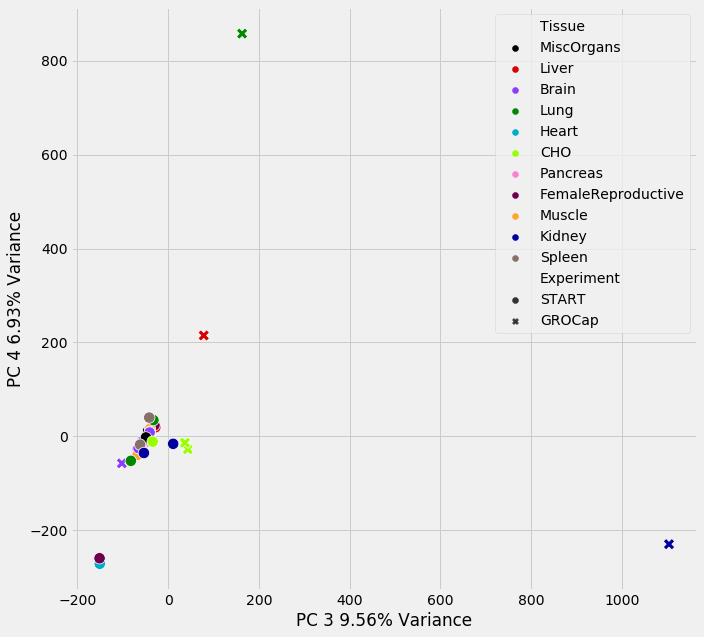

In [16]:
#run_pca(peaks_expression_norm_log2)
run_pca(peaks_expression_norm_log2.loc[:,~peaks_expression_norm_log2.columns.str.contains("BMDM")])
